In [77]:
import model.db_fonction as db_f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

conn = db_f.sqlite3.connect("bdd/lendsmart_bdd.db")
conn.execute('PRAGMA foreign_keys = ON')
conn.execute('PRAGMA writable_schema=ON')
cur = conn.cursor()

1. Analyse des Matériaux

    Utilisation des Matériaux : Analysez la fréquence d'emprunt des différents matériaux pour identifier les plus et les moins populaires. Cela peut aider à optimiser les achats futurs ou la gestion des stocks.
    
    Durabilité des Matériaux : Étudiez la corrélation entre la fréquence d'utilisation des matériaux et leur taux de défaillance ou leur marquage comme deleted pour évaluer leur durabilité.

2. Analyse des Emprunts

    Durée des Emprunts : Calculez la durée moyenne des prêts et analysez les variations selon le type de matériel ou le profil de l'emprunteur.

    Prêts en Retard : Identifiez les patterns parmi les prêts qui sont souvent en retard. Examinez si certains types de matériaux ou certains emprunteurs sont plus susceptibles de rendre les articles en retard.
    
    Statut des Prêts : Réalisez une analyse de la distribution des différents statuts de prêts (en cours, terminé, en retard, etc.) pour évaluer l'efficacité des processus de prêt.

In [78]:
#---- Création du dataframe de base ----#
data = db_f.select_borrowed(cur)
if data:
    df = pd.DataFrame(data)
    df = df.set_axis(['id_borrowed', 'loan_date', 'deadline','return_date','status','id_material','reference_material','designation_material','description_material'], axis=1, inplace=False)
else:
    print("Aucune donnée récupérée.")

#---- Convertir les colonnes en datetime ----#
df['loan_date'] = pd.to_datetime(df['loan_date'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['return_date'] = pd.to_datetime(df['return_date'])

#---- création de la colonne de la durée du prêt ----#
df['days_borrowed'] = (df['return_date'] - df['loan_date']).dt.days

#---- Filtrage des données inutiles ----#
df_clean = df.dropna(subset=['days_borrowed', 'id_material'])

#---- Calculer la moyenne des durées de prêt par matériel ----#
mean_duration_per_material = df_clean.groupby(['reference_material','designation_material'])['days_borrowed'].mean()
mean_duration_per_material = mean_duration_per_material.reset_index()
mean_duration_per_material.rename(columns={'days_borrowed': 'mean_days_borrowed'}, inplace=True)

/tmp/ipykernel_14129/67764266.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(['id_borrowed', 'loan_date', 'deadline','return_date','status','id_material','reference_material','designation_material','description_material'], axis=1, inplace=False)


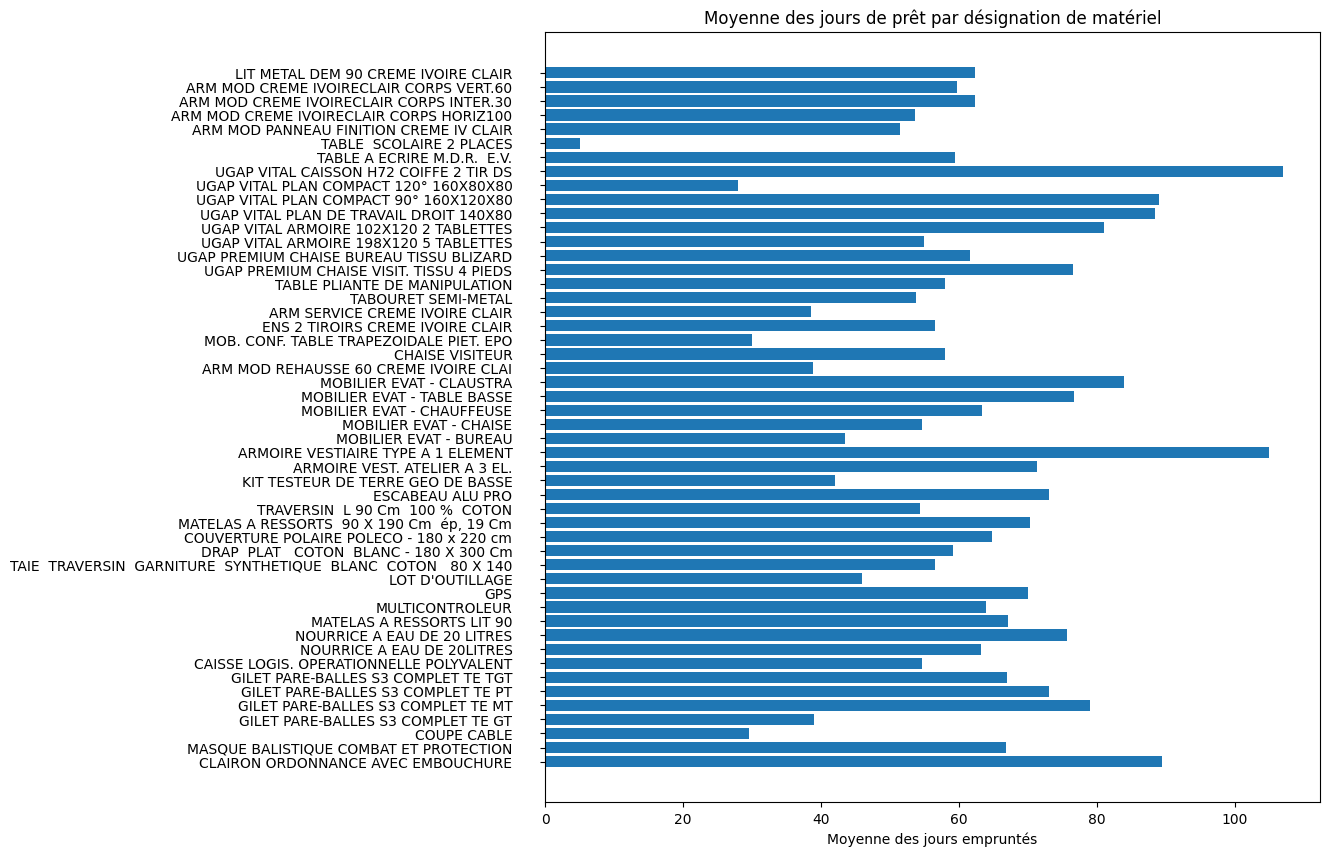

In [79]:
#---- Création du graph ----#
fig, ax = plt.subplots(figsize=(10, 10))

y_pos = np.arange(len(mean_duration_per_material['designation_material']))
ax.barh(y_pos, mean_duration_per_material['mean_days_borrowed'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(mean_duration_per_material['designation_material'],fontsize=10)
ax.yaxis.set_tick_params(pad=20)
ax.invert_yaxis()
ax.set_xlabel('Moyenne des jours empruntés')
ax.set_title('Moyenne des jours de prêt par désignation de matériel')
plt.show()

en cours     3453
en retard     288
Name: status, dtype: int64


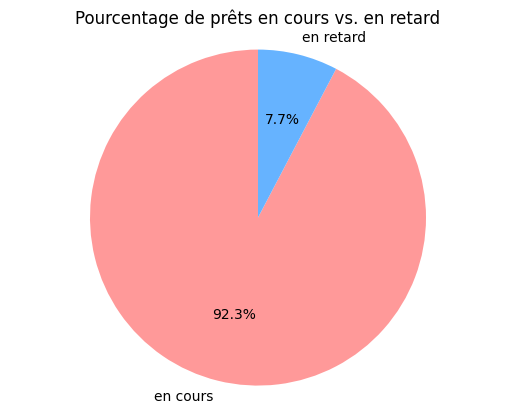

In [80]:
#camember de tout les prêt
#pourcentage sur tout les prêts en cours et entre en retard et dans les temps.

#---- Déterminer si le prêt est en cours ou en retard ----#
today = pd.to_datetime('2024-05-06')
df['status'] = df.apply(lambda row: 'en retard' if row['deadline'] < today and pd.isna(row['return_date']) else 'en cours', axis=1)

status_counts = df['status'].value_counts()
print(status_counts)


fig, ax = plt.subplots()
ax.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
ax.axis('equal') 
plt.title('Pourcentage de prêts en cours vs. en retard')
plt.show()


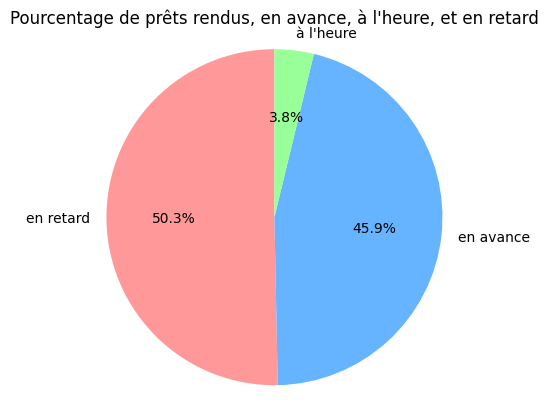

In [81]:
data = db_f.execute_query("SELECT id, loan_date, deadline, return_date, status FROM borrowed WHERE status = 'close' AND return_date IS NOT NULL", cur)

if data:
    df = pd.DataFrame(data)
    df.columns = ['id_borrowed', 'loan_date', 'deadline', 'return_date', 'status']
else:
    print("Aucune donnée récupérée.")

# Assurez-vous que les dates sont des objets datetime pour permettre la comparaison
df['loan_date'] = pd.to_datetime(df['loan_date'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['return_date'] = pd.to_datetime(df['return_date'])

# Analyse du rendu des prêts
df['loan_status'] = df.apply(
    lambda row: 'en retard' if row['deadline'] < row['return_date'] else (
        "à l'heure" if row['deadline'] == row['return_date'] else 'en avance'), axis=1)

# Comptage des résultats pour le graphique
status_counts = df['loan_status'].value_counts()

# Création du graphique en secteurs
fig, ax = plt.subplots()
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Rouge pour en retard, bleu pour à l'heure, vert pour en avance
ax.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')
plt.title("Pourcentage de prêts rendus, en avance, à l'heure, et en retard")
plt.show()

3. Analyse des Emprunteurs

    Segmentation des Emprunteurs : Utilisez des techniques de clustering pour segmenter les emprunteurs en fonction de leur activité d'emprunt et d'autres métriques pertinentes comme la fréquence, la durée des prêts, et le taux de retard.
    
    Profils d'Emprunteurs : Déterminez les caractéristiques des emprunteurs qui influencent le plus les modalités de prêt, comme les retards ou les types de matériaux empruntés.

/tmp/ipykernel_14129/1570541792.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['compagny'], rotation=45, ha='right')


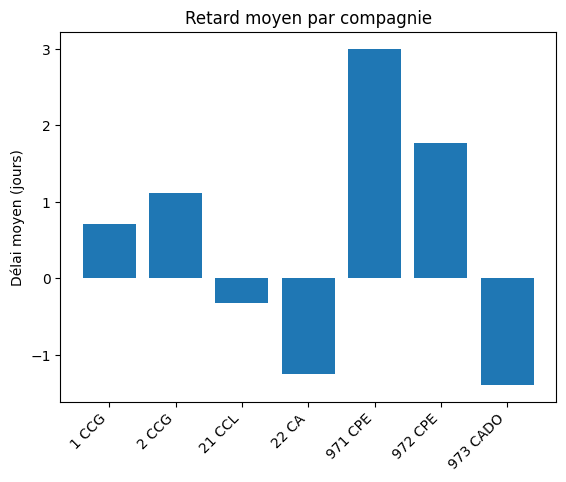

In [82]:
#---- Le retard en moyenne par compagnie des réintégration ----#
query = """
            WITH borrowed_close AS (
                SELECT 
                    bor.id AS borrowed_id,
                    bor.loan_date,
                    bor.deadline,
                    bor.return_date,
                    bor.status,
                    bom.id_material,
                    bor.id_person,
                    round(julianday(bor.return_date) - julianday(bor.deadline)) AS delay
                FROM 
                    borrowed AS bor
                JOIN
                    borrowed_material AS bom 
                    ON bor.id = bom.id_borrowed
                WHERE
                    bor.status = 'close'
                    AND bor.deadline IS NOT NULL 
                    AND bor.return_date IS NOT NULL
            )

            SELECT
                ide.compagny,
                AVG(boc.delay) AS average_delay
            FROM
                borrowed_close AS boc
            JOIN
                person AS per
                ON boc.id_person = per.id
            JOIN
                identity AS ide 
                ON per.id = ide.id_person
            WHERE
                per.deleted = 0
            GROUP BY
                ide.compagny;
        """
data = db_f.execute_query(query, cur)
if data:
    df = pd.DataFrame(data)
    df.columns = ['compagny', 'average_delay']
else:
    print("Aucune donnée récupérée.")

if not df.empty:
    fig, ax = plt.subplots()
    ax.bar(df['compagny'], df['average_delay'], color='tab:blue')

    ax.set_ylabel('Délai moyen (jours)')
    ax.set_title('Retard moyen par compagnie')
    ax.set_xticklabels(df['compagny'], rotation=45, ha='right')

    plt.show()
else:
    print("DataFrame is empty - no data to plot.")

5. Corrélation et Prédictions

    Modèles Prédictifs : Développez des modèles pour prédire les risques de retard ou les probabilités de dommage en fonction des caractéristiques des prêts et des emprunteurs.
    
    Corrélation entre Catégories et Usage : Analysez si certaines catégories de matériaux sont plus utilisées que d'autres et les relations possibles avec d'autres variables comme les saisons, les événements spéciaux, ou les changements dans l'organisation.

6. Rapports et Tableaux de Bord

    Tableaux de Bord de Suivi : Créez des dashboards interactifs pour le suivi en temps réel des prêts, des retours, et des statuts des matériaux pour une gestion opérationnelle quotidienne.

In [83]:
conn.commit()
conn.close()